# Imports set up rendering

In [1]:
#@title Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=osmesa
os.environ['MUJOCO_GL'] = 'osmesa'

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true "
    "--xla_gpu_triton_gemm_any=True "
    # "--xla_gpu_enable_async_collectives=true "
    # "--xla_gpu_enable_latency_hiding_scheduler=true "
    # "--xla_gpu_enable_highest_priority_async_stream=true "
)
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.90"
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 1

Sun Oct  6 14:40:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 39%   57C    P8             19W /  300W |      11MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%load_ext autoreload
%autoreload 2
import functools
import os
import pickle
import warnings
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Text, Tuple, Union

import imageio
import jax
import mediapy as media
import mujoco
import numpy as np
import PIL.ImageDraw
import wandb
import yaml
from brax import base, envs
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax import struct
from IPython.display import HTML
from jax import numpy as jp
from matplotlib import pyplot as plt
from ml_collections import config_dict
from mujoco import mjx
import jax
from jax import numpy as jp

from brax.io import mjcf as mjcf_brax
from brax import math as brax_math
from dial_mpc.utils import io_dict_to_hdf5 as ioh5


# from brax.training.agents.ppo import train as ppo
# import custom_brax.custom_ppo as ppo
# import custom_brax.custom_wrappers as custom_wrappers
# from preprocessing.preprocess import process_clip_to_train
# from envs.fruitfly import Fruitfly_Tethered, Fruitfly_Tethered_Free
# from utils.utils import *

warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra

# with initialize(version_base=None, config_path="dial_mpc/configs"):
#     cfg=compose(config_name='config.yaml',overrides= ["dataset=fly_run", "train=train_fly_run", "paths=walle"],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg)

In [3]:
model_path = ("/home/eabe/Research/MyRepos/dial-mpc/dial_mpc/models/fruitfly/fruitfly_force_fast.xml")
# sys = mjcf.load(model_path)
root = mujoco.MjModel.from_xml_path(model_path)


In [8]:
dpath = Path('/home/eabe/Research/Github/dial-mpc/flybody/0.h5')
import dial_mpc.utils.io_dict_to_hdf5 as ioh5

ref_data = ioh5.load(dpath)
for key, val in ref_data.items():
    ref_data[key] = jp.array(val)

In [9]:
dpath = '/home/eabe/Research/MyRepos/dial-mpc/flybody/0.h5'
ref_data = ioh5.load(dpath)

In [13]:
from dial_mpc.utils.preprocess import ReferenceClip
ref_clip = ioh5.load(dpath)
clip = ReferenceClip()
clip = clip.replace(
    position=ref_clip['position'],
    quaternion=ref_clip['quaternion'],
    joints=ref_clip['joints'],
    body_positions=ref_clip['body_positions'],
    velocity=ref_clip['velocity'],
    joints_velocity=ref_clip['joints_velocity'],
    angular_velocity=ref_clip['angular_velocity'],
    body_quaternions=ref_clip['body_quaternions'],
)

In [4]:
mpc_dir = Path('/home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody')

In [6]:
mpc_data = sorted(list(mpc_dir.glob('*.npy')))
for n,conf in enumerate(mpc_data):
    print(n,conf)
n=4
predictions = np.load(mpc_data[n])
states = np.load(mpc_data[n+1])

0 /home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody/20241006-010151_predictions.npy
1 /home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody/20241006-010151_states.npy
2 /home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody/20241006-014252_predictions.npy
3 /home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody/20241006-014252_states.npy
4 /home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody/20241006-143921_predictions.npy
5 /home/eabe/Research/MyRepos/dial-mpc/dial_mpc/envs/flybody/20241006-143921_states.npy


In [7]:
times = states[:, 0]
qpos = states[:,1:root.nq]
qvel = states[:,root.nq:root.nq+root.nv]
ctrl = states[:,root.nq+root.nv:root.nq+root.nv+root.nu]

In [9]:
model_path = ("/home/eabe/Research/MyRepos/dial-mpc/dial_mpc/models/fruitfly/fruitfly_force_fast.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
first_joint.delete()
root = spec.compile()
root.opt.timestep = 0.0002
data = mujoco.MjData(root)
n_frames = 200
height = 240
width = 320
frames = []
fps = 1/.002
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

rollout = []
with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl[i]
        while data.time < i/fps:
            mujoco.mj_step(root, data)
        times.append(data.time)
        # sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        rollout.append(data)
            
# # grab a trajectory
# for i in range(times.shape[0]):
#     data.ctrl = ctrl[i]
#     state = mujoco.mj_step(root,data)
#     rollout.append(state)

media.show_video(frames, fps=50)
# pixels = env.render(rollout, width=1000, height=1000, camera=3,scene_option=scene_option) 

In [26]:

scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 0, 0, 0, 1, 0]
scene_option.sitegroup[:] = [0, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# pixels = env.render(rollout, width=1000, height=1000, camera=1,scene_option=scene_option) 
media.show_video(pixels, fps=50)

((400,), (400, 42), (400, 42), (400, 36))

In [ ]:
_GEOM_TYPE_NAMES = {
    0: 'Plane',
    1: 'HeightMap',
    2: 'Sphere',
    3: 'Capsule',
    5: 'Cylinder',
    6: 'Box',
    7: 'Mesh',
}
for id_ in range(sys.ngeom):
    print(_GEOM_TYPE_NAMES[sys.geom_type[id_]],)

In [9]:
sys.geom_type

array([0, 7, 4, 4, 7, 4, 7, 7, 7, 7, 7, 3, 3, 4, 7, 7, 3, 7, 7, 4, 7, 4,
       7, 3, 7, 7, 3, 7, 7, 4, 7, 4, 4, 6, 7, 4, 7, 4, 4, 6, 7, 7, 5, 7,
       7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 2, 7, 7, 7, 7, 4,
       7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 4, 7, 3, 7, 3, 7, 3,
       7, 3, 7, 3, 7, 3, 7, 3, 7, 4, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3,
       7, 3, 7, 4, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 4, 7, 3,
       7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 4, 7, 3, 7, 3, 7, 3, 7, 3,
       7, 3, 7, 3, 7, 3], dtype=int32)

In [3]:
from absl import app, flags

FLAGS = flags.FLAGS

n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")

flags.DEFINE_enum("solver", "cg", ["cg", "newton"], "constraint solver")
flags.DEFINE_integer("iterations", 4, "number of solver iterations")
flags.DEFINE_integer("ls_iterations", 4, "number of linesearch iterations")

Using 1 GPUs


In [ ]:
mjcf_path = 'assets/fruitfly/fruitfly_force_fast.xml'        
root = mujoco.MjModel.from_xml_path(mjcf_path)

sys = mjcf_brax.load_mjmodel(mjcf_path)

In [8]:
import itertools
from typing import Dict, Optional, Tuple, Union
from xml.etree import ElementTree

from brax import math
from brax.base import (
    Actuator,
    DoF,
    Inertia,
    Link,
    Motion,
    System,
    Transform,
)
from etils import epath
import jax
from jax import numpy as jp
import mujoco
from mujoco import mjx
import numpy as np
from brax.io.mjcf import *
from brax.io.mjcf import (
    _fuse_bodies,
    _get_meshdir,
    _find_assets
)

In [9]:
elem = ElementTree.fromstring(epath.Path(mjcf_path).read_text())
_fuse_bodies(elem)
meshdir = _get_meshdir(elem)
assets = _find_assets(elem, epath.Path(mjcf_path), meshdir)
xml = ElementTree.tostring(elem, encoding='unicode')
mj = mujoco.MjModel.from_xml_string(xml, assets=assets)

ValueError: XML Error: multiple orientation specifiers are not allowed
Element 'geom', line 553


In [14]:
print(xml)

<mujoco model="fruitfly">
  <compiler autolimits="true" angle="radian" />

  <option gravity="0 0 -981" density="0.00128" viscosity="0.000185" cone="elliptic" noslip_iterations="3" />

  <size nkey="1" />

  <default>
    <mesh scale="0.1 0.1 0.1" />
    <geom friction="0.5" solref="0.0002 1" solimp="0.95 0.99 0.01" />
    <general ctrllimited="true" />
    <default class="body">
      <joint limited="true" solreflimit="0.001 1" armature="1e-02" />
      <geom type="mesh" contype="0" conaffinity="0" group="1" material="body" density="0.478" />
      <site group="3" size="0.01" />
      <default class="collision">
        <geom type="capsule" contype="0" conaffinity="0" condim="1" group="4" material="blue" density="0" />
        <default class="adhesion-collision">
          <geom material="pink" friction="0.6" margin="0.0005" gap="0.0005" contype="1" conaffinity="1" />
          <site type="capsule" />
        </default>
        <default class="collision-membrane">
          <geom grou

In [5]:
data = mujoco.MjData(root)
mujoco.mj_forward(root,data)

In [6]:
data.qpos = root.keyframe('home').qpos
mujoco.mj_forward(root,data)

# Load configs

In [4]:
dataset = 'Flybody'
version = 'debug'
# version = 'partial_obs'
base_dir = Path(f'/data/users/eabe/biomech_model/{dataset}/RL_{dataset}/{version}')
configs = sorted(list(base_dir.rglob('*run_config.yaml')))
for n,conf in enumerate(configs):
    print(n,conf)


n = 0
cfg_path =configs[n]
cfg = load_cfg(cfg_path)

0 /data/users/eabe/biomech_model/Flybody/RL_Flybody/debug/train.note=glados,train=train_fly_run/logs/run_config.yaml


In [4]:
cfg.dataset.env_args['iterations'] = 6
cfg.dataset.env_args['ls_iterations'] = 6
cfg.dataset.env_args['physics_steps_per_control_step'] = 10
# cfg.dataset.env_args['mocap_hz'] = 6

cfg.dataset.env_args['clip_length'] = 601

In [5]:
for k in cfg.paths.keys():
    if k != 'user':
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
env_cfg = cfg.dataset
env_args = cfg.dataset.env_args
reference_path = cfg.paths.data_dir/ f"clips/{env_cfg['clip_idx']}.p"
reference_path.parent.mkdir(parents=True, exist_ok=True)

if os.path.exists(reference_path):
    with open(reference_path, "rb") as file:
        # Use pickle.load() to load the data from the file
        reference_clip = pickle.load(file)
else:
    # Process rodent clip and save as pickle
    reference_clip = process_clip_to_train(
        env_cfg["stac_path"],
        start_step=env_cfg["clip_idx"] * env_args["clip_length"],
        clip_length=env_args["clip_length"],
        mjcf_path=env_args["mjcf_path"],
    )
    with open(reference_path, "wb") as file:
        # Use pickle.dump() to save the data to the file
        pickle.dump(reference_clip, file)

In [7]:


def get_config():
    """Returns reward config for barkour quadruped environment."""

    def get_default_rewards_config():
        default_config = config_dict.ConfigDict(
            dict(
                # The coefficients for all reward terms used for training. All
                # physical quantities are in SI units, if no otherwise specified,
                # i.e. joint positions are in rad, positions are measured in meters,
                # torques in Nm, and time in seconds, and forces in Newtons.
                scales=config_dict.ConfigDict(
                    dict(
                        # Tracking rewards are computed using exp(-delta^2/sigma)
                        # sigma can be a hyperparameters to tune.
                        # Track the base x-y velocity (no z-velocity tracking.)
                        tracking_lin_vel=1.5,
                        # Penalize non-zero roll and pitch angles. L2 penalty.
                        orientation=-5.0,
                        # L2 regularization of joint torques, |tau|^2.
                        torques=0, # -0.0002
                        # Penalize the change in the action and encourage smooth
                        # actions. L2 regularization |action - last_action|^2
                        action_rate=-0.01,
                        # Encourage long swing steps.  However, it does not
                        stand_still=-0.5,
                        # Early termination penalty.
                        termination=-1.0,
                        # ignore position reward
                        pos_reward=0,
                        # encourage the robot to face forward
                        quat_reward=1.0,
                        # encourage the robot to keep its joints close to the reference
                        joint_reward=5.0,
                        # encourage the robot to keep its angular velocity close to the reference
                        angvel_reward=1.0,
                        # encourage the robot to keep its body positions close to the reference
                        bodypos_reward=0,
                        # encourage the robot to keep its end effectors close to the reference
                        endeff_reward=0,
                        # 
                        healthy_reward = 1.0,
                        
                        
                    )
                ),
                # Tracking reward = exp(-error^2/sigma).
                tracking_sigma=0.25,
            )
        )
        return default_config

    default_config = config_dict.ConfigDict(
        dict(
            rewards=get_default_rewards_config(),
        )
    )

    return default_config

class Fruitfly_Run(PipelineEnv):
    """Environment for training the barkour quadruped joystick policy in MJX."""

    def __init__(
        self,
        reference_clip,
        center_of_mass: str,
        end_eff_names: List[str],
        appendage_names: List[str],
        body_names: List[str],
        joint_names: List[str],
        mocap_hz: int = 200,
        mjcf_path: str = "./assets/fruitfly/fruitfly_force_fast.xml",
        obs_noise: float = 0.05,
        action_scale: float = 3,
        ref_len: int = 5,
        too_far_dist=0.1,
        bad_pose_dist=jp.inf,
        bad_quat_dist=jp.inf,
        ctrl_cost_weight=0.01,
        pos_reward_weight=0.0,
        quat_reward_weight=1.0,
        joint_reward_weight=10.0,
        angvel_reward_weight=1.0,
        bodypos_reward_weight=0.0,
        endeff_reward_weight=0.0,
        healthy_reward=0.25,
        healthy_z_range=(0.03, 0.5),
        physics_steps_per_control_step=10,
        reset_noise_scale=1e-3,
        solver="cg",
        iterations: int = 6,
        ls_iterations: int = 6,
        terminate_when_unhealthy=True,
        free_jnt=True,
        **kwargs,
    ):
        spec = mujoco.MjSpec()
        spec.from_file(mjcf_path)
        thorax = spec.find_body("thorax")
        first_joint = thorax.first_joint()
        if (free_jnt == False) & (first_joint.name == "free"):
            first_joint.delete()
        root = spec.compile()

        
        mj_model = root
        mj_model.opt.solver = {
            "cg": mujoco.mjtSolver.mjSOL_CG,
            "newton": mujoco.mjtSolver.mjSOL_NEWTON,
        }[solver.lower()]
        mj_model.opt.iterations = iterations
        mj_model.opt.ls_iterations = ls_iterations
        mj_model.opt.timestep = 2e-4
        mj_model.opt.jacobian = 0

        sys = mjcf_brax.load_model(mj_model)

        self._dt = 0.01  # this environment is 50 fps
        # sys = sys.tree_replace({"opt.timestep": 0.002})

        kwargs["n_frames"] = kwargs.get("n_frames", physics_steps_per_control_step)

        print(physics_steps_per_control_step)
        super().__init__(sys, backend="mjx", n_frames=physics_steps_per_control_step, debug=True)

        self.reward_config = get_config()
        # set custom from kwargs
        for k, v in kwargs.items():
            if k.endswith("_scale"):
                self.reward_config.rewards.scales[k[:-6]] = v

        self._thorax_idx = mujoco.mj_name2id(
            sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, "thorax"
        )
        max_physics_steps_per_control_step = int(
            (1.0 / (mocap_hz * sys.opt.timestep))
        )
        self._steps_for_cur_frame = (
            max_physics_steps_per_control_step / physics_steps_per_control_step
        )
        self._action_scale = action_scale
        self._obs_noise = obs_noise
        self._reset_noise_scale = reset_noise_scale
        self._init_q = jp.array(sys.mj_model.keyframe("home").qpos)
        self._default_pose = sys.mj_model.keyframe("home").qpos[7:]
        self.lowers = jp.array(
            [
                -2,
            ]
            * 36
        )
        self.uppers = jp.array(
            [
                2,
            ]
            * 36
        )

        self._thorax_idx = mujoco.mj_name2id(
            mj_model, mujoco.mju_str2Type("body"), center_of_mass
        )

        self._joint_idxs = jp.array(
            [
                mujoco.mj_name2id(mj_model, mujoco.mju_str2Type("joint"), joint)
                for joint in joint_names
            ]
        )

        self._body_idxs = jp.array(
            [
                mujoco.mj_name2id(mj_model, mujoco.mju_str2Type("body"), body)
                for body in body_names
            ]
        )
        _endeff_idxs = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
            for f in end_eff_names
        ]
        assert not any(id_ == -1 for id_ in _endeff_idxs), "Site not found."
        self._endeff_idxs = jp.array(_endeff_idxs)
        lower_leg_body = [
            "tarsus_T1_left",
            "tarsus_T1_right",
            "tarsus_T2_left",
            "tarsus_T2_right",
            "tarsus_T3_left",
            "tarsus_T3_right",
        ]
        lower_leg_body_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
            for l in lower_leg_body
        ]
        assert not any(id_ == -1 for id_ in lower_leg_body_id), "Body not found."
        self._lower_leg_body_id = jp.array(lower_leg_body_id)
        self._foot_radius = 0.0175
        self._nv = sys.nv
        self._nq = sys.nq
        self._nu = sys.nu
        
        self._free_jnt = free_jnt
        self._mocap_hz = mocap_hz
        self._bad_pose_dist = bad_pose_dist
        self._too_far_dist = too_far_dist
        self._bad_quat_dist = bad_quat_dist
        self._ref_traj = reference_clip
        self._ref_len = ref_len
        self._pos_reward_weight = pos_reward_weight
        self._quat_reward_weight = quat_reward_weight
        self._joint_reward_weight = joint_reward_weight
        self._angvel_reward_weight = angvel_reward_weight
        self._bodypos_reward_weight = bodypos_reward_weight
        self._endeff_reward_weight = endeff_reward_weight
        self._ctrl_cost_weight = ctrl_cost_weight
        self._healthy_reward = healthy_reward
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        self._terminate_when_unhealthy = terminate_when_unhealthy

    def sample_command(self, rng: jax.Array) -> jax.Array:
        lin_vel_x = [-0.6, 1.5]  # min max [m/s]
        # lin_vel_y = [-0.8, 0.8]  # min max [m/s]
        # ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

        _, key1 = jax.random.split(rng, 2)
        lin_vel_x = jax.random.uniform(
            key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
        )
        # lin_vel_y = jax.random.uniform(
        #     key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
        # )
        # ang_vel_yaw = jax.random.uniform(
        #     key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
        # )
        new_cmd = jp.array([lin_vel_x[0], 0, 0])
        return new_cmd

    def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
        rng, key = jax.random.split(rng)

        data = self.pipeline_init(self._init_q, jp.zeros(self._nv))

        info = {
            "rng": rng,
            "cur_frame": 0,
            "steps_taken_cur_frame": 0,
            "last_act": jp.zeros(self._nu),
            "last_vel": jp.zeros(self._nv),
            "command": self.sample_command(key),
            "last_contact": jp.zeros(6, dtype=bool),
            "rewards": {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
            "step": 0,
            "quat_distance": 0.0,
            "joint_distance": 0.0,
        }

        obs_history = jp.zeros(15 * 91)  # store 15 steps of history
        obs = self._get_obs(data, info, obs_history)
        reward, done = jp.zeros(2)
        metrics = {"total_dist": 0.0}
        for k in info["rewards"]:
            metrics[k] = info["rewards"][k]

        return State(
            data, obs, reward, done, metrics, info
        )  # pytype: disable=wrong-arg-types

    def step(
        self, state: State, action: jax.Array
    ) -> State:  # pytype: disable=signature-mismatch
        rng, cmd_rng = jax.random.split(state.info["rng"], 2)
        
        data0 = state.pipeline_state
        data = self.pipeline_step(data0, action)
        
        state.info["steps_taken_cur_frame"] += 1
        state.info["cur_frame"] += jp.where(
            state.info["steps_taken_cur_frame"] == self._steps_for_cur_frame, 1, 0
        )
        state.info["steps_taken_cur_frame"] *= jp.where(
            state.info["steps_taken_cur_frame"] == self._steps_for_cur_frame, 0, 1
        )
        # physics step
        # motor_targets = self._default_pose + action * self._action_scale
        # motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
        # data = self.pipeline_step(state.data, motor_targets)
        cur_frame = state.info["cur_frame"]
        track_pos = self._ref_traj.position
        pos_distance = data.qpos[:3] - track_pos[cur_frame]
        pos_reward = jp.exp(
            -400 * jp.sum(pos_distance) ** 2
        )
        track_quat = self._ref_traj.quaternion
        quat_distance = jp.sum(
            self._bounded_quat_dist(data.qpos[3:7], track_quat[cur_frame]) ** 2
        )
        quat_reward = jp.exp(-4.0 * quat_distance)
        
        track_joints = self._ref_traj.joints
        joint_distance = jp.sum(data.qpos[7:] - track_joints[cur_frame]) ** 2
        joint_reward = jp.exp(-0.5 * joint_distance)
        state.info["joint_distance"] = joint_distance

        track_angvel = self._ref_traj.angular_velocity
        angvel_reward = jp.exp(
            -0.5 * jp.sum(data.qvel[3:6] - track_angvel[cur_frame]) ** 2
        )
        track_bodypos = self._ref_traj.body_positions
        bodypos_reward = jp.exp(
            -6.0
            * jp.sum(
                (
                    data.xpos[self._body_idxs]
                    - track_bodypos[cur_frame][self._body_idxs]
                ).flatten()
            )
            ** 2
        )

        endeff_reward = jp.exp(
            -0.75
            * jp.sum(
                (
                    data.xpos[self._endeff_idxs]
                    - track_bodypos[cur_frame][self._endeff_idxs]
                ).flatten()
            )
            ** 2
        )
        x, xd = data.x, data.xd
        
        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(data.xpos[self._thorax_idx][2] < min_z, 0.0, 1.0)
        is_healthy = jp.where(data.xpos[self._thorax_idx][2] > max_z, 0.0, is_healthy)
        healthy_reward = self._healthy_reward
        state.info["quat_distance"] = quat_distance
        bad_quat = jp.where(quat_distance > self._bad_quat_dist, 1.0, 0.0)
        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
        # jax.debug.print(f'is_healthy: {is_healthy}')



        # observation data
        obs = self._get_obs(data, state.info, state.obs)
        joint_angles = data.q[7:]
        joint_vel = data.qd  ##### need to restrict to only legs

        # foot contact data based on z-position
        foot_pos = data.site_xpos[
            self._endeff_idxs
        ]  # pytype: disable=attribute-error
        foot_contact_z = foot_pos[:, 2] - self._foot_radius
        contact = foot_contact_z < 1e-3  # a mm or less off the floor
        contact_filt_mm = contact | state.info["last_contact"]
        contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]
        

        # done if joint limits are reached or robot is falling
        up = jp.array([0.0, 0.0, 1.0])
        done = jp.dot(brax_math.rotate(up, x.rot[self._thorax_idx]), up) < 0
        done |= jp.any(joint_angles < self.lowers)
        done |= jp.any(joint_angles > self.uppers)
        done |= data.x.pos[self._thorax_idx, 2] < -0.14
        done |= data.x.pos[self._thorax_idx, 2] > 0.1
        
        # reward
        rewards = {
            'joint_reward': joint_reward,
            'pos_reward': pos_reward,
            'quat_reward': quat_reward,
            'angvel_reward': angvel_reward,
            'bodypos_reward': bodypos_reward,
            'endeff_reward': endeff_reward,
            'healthy_reward': healthy_reward,
            "tracking_lin_vel": (
                self._reward_tracking_lin_vel(state.info["command"], x, xd)
            ),
            "orientation": self._reward_orientation(x),
            "torques": self._reward_torques(
                data.qfrc_actuator
            ),  # pytype: disable=attribute-error
            "action_rate": self._reward_action_rate(action, state.info["last_act"]),
            "stand_still": self._reward_stand_still(
                state.info["command"],
                joint_angles,
            ),
            "termination": self._reward_termination(done, state.info["step"]),
        }
        rewards = {
            k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
        }
        reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)
        

        # Handle nans during sim by resetting env
        reward = jp.nan_to_num(reward)
        obs = jp.nan_to_num(obs)

        # from jax.flatten_util import ravel_pytree

        # done =  1 - is_healthy if self._terminate_when_unhealthy else 0.0
        # flattened_vals, _ = ravel_pytree(data)
        # num_nans = jp.sum(jp.isnan(flattened_vals))
        # nan = jp.where(num_nans > 0, 1.0, 0.0)
        # jax.debug.print(f'nan: {nan}, done: {done}')
        # done = jp.max(jp.array([nan, done]))
        
        # state management
        state.info["last_act"] = action
        state.info["last_vel"] = joint_vel
        state.info["last_contact"] = contact
        state.info["rewards"] = rewards
        state.info["step"] += 1
        state.info["rng"] = rng

        # sample new command if more than 500 timesteps achieved
        state.info["command"] = jp.where(
            state.info["step"] > 500,
            self.sample_command(cmd_rng),
            state.info["command"],
        )
        
        # reset the step counter when done
        state.info["step"] = jp.where(
            done | (state.info["step"] > 500), 0, state.info["step"]
        )

        # log total displacement as a proxy metric
        state.metrics["total_dist"] = brax_math.normalize(x.pos[self._thorax_idx])[1]
        state.metrics.update(state.info["rewards"])

        done = jp.float32(done)

        
        state = state.replace(
            pipeline_state=data, obs=obs, reward=reward, done=done
        )
        return state

    def _get_obs(
        self,
        data: base.State,
        info: dict[str, Any],
        obs_history: jax.Array,
    ) -> jax.Array:
        inv_torso_rot = brax_math.quat_inv(data.x.rot[0])
        local_rpyrate = brax_math.rotate(data.xd.ang[0], inv_torso_rot)

        obs = jp.concatenate(
            [
                jp.array([local_rpyrate[2]]) * 0.25,  # yaw rate
                brax_math.rotate(
                    jp.array([0, 0, -1]), inv_torso_rot
                ),  # projected gravity
                info["command"] * jp.array([2.0, 2.0, 0.25]),  # command
                data.q[7:] - self._default_pose,  # motor angles
                info["last_act"],  # last action
            ]
        )

        # clip, noise
        obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
            info["rng"], obs.shape, minval=-1, maxval=1
        )
        # stack observations through time
        obs = jp.roll(obs_history, obs.size).at[: obs.size].set(obs)

        return obs

    # ------------ reward functions----------------
    def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
        # Penalize z axis base linear velocity
        return jp.square(xd.vel[0, 2])

    def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
        # Penalize xy axes base angular velocity
        return jp.sum(jp.square(xd.ang[0, :2]))

    def _reward_orientation(self, x: Transform) -> jax.Array:
        # Penalize non flat base orientation
        up = jp.array([0.0, 0.0, 1.0])
        rot_up = brax_math.rotate(up, x.rot[0])
        return jp.sum(jp.square(rot_up[:2]))

    def _reward_torques(self, torques: jax.Array) -> jax.Array:
        # Penalize torques
        return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

    def _reward_action_rate(self, act: jax.Array, last_act: jax.Array) -> jax.Array:
        # Penalize changes in actions
        return jp.sum(jp.square(act - last_act))

    def _reward_tracking_lin_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of linear velocity commands (xy axes)
        local_vel = brax_math.rotate(xd.vel[0], brax_math.quat_inv(x.rot[0]))
        lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
        lin_vel_reward = jp.exp(
            -lin_vel_error / self.reward_config.rewards.tracking_sigma
        )
        return lin_vel_reward

    def _reward_tracking_ang_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of angular velocity commands (yaw)
        base_ang_vel = brax_math.rotate(xd.ang[0], brax_math.quat_inv(x.rot[0]))
        ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
        return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

    def _reward_feet_air_time(
        self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
    ) -> jax.Array:
        # Reward air time.
        rew_air_time = jp.sum((air_time - 0.1) * first_contact)
        rew_air_time *= (
            brax_math.normalize(commands[:2])[1] > 0.05
        )  # no reward for zero command
        return rew_air_time

    def _reward_stand_still(
        self,
        commands: jax.Array,
        joint_angles: jax.Array,
    ) -> jax.Array:
        # Penalize motion at zero commands
        return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
            brax_math.normalize(commands[:2])[1] < 0.1
        )

    def _reward_foot_slip(
        self, data: base.State, contact_filt: jax.Array
    ) -> jax.Array:
        # get velocities at feet which are offset from lower legs
        # pytype: disable=attribute-error
        pos = data.site_xpos[self._endeff_idxs]  # feet position
        feet_offset = pos - data.xpos[self._lower_leg_body_id]
        # pytype: enable=attribute-error
        offset = base.Transform.create(pos=feet_offset)
        foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
        foot_vel = offset.vmap().do(data.xd.take(foot_indices)).vel

        # Penalize large feet velocity for feet that are in contact with the ground.
        return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))

    def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
        return done & (step < 500)
    
    def _bounded_quat_dist(self, source: np.ndarray, target: np.ndarray) -> np.ndarray:
        """Computes a quaternion distance limiting the difference to a max of pi/2.

        This function supports an arbitrary number of batch dimensions, B.

        Args:
          source: a quaternion, shape (B, 4).
          target: another quaternion, shape (B, 4).

        Returns:
          Quaternion distance, shape (B, 1).
        """
        source /= jp.linalg.norm(source, axis=-1, keepdims=True)
        target /= jp.linalg.norm(target, axis=-1, keepdims=True)
        # "Distance" in interval [-1, 1].
        dist = 2 * jp.einsum("...i,...i", source, target) ** 2 - 1
        # Clip at 1 to avoid occasional machine epsilon leak beyond 1.
        dist = jp.minimum(1.0, dist)
        # Divide by 2 and add an axis to ensure consistency with expected return
        # shape and magnitude.
        return 0.5 * jp.arccos(dist)[..., np.newaxis]

    def render(
        self,
        trajectory: List[base.State],
        camera: str | None = None,
        width: int = 480,
        height: int = 320,
        scene_option: Any = None,
    ) -> Sequence[np.ndarray]:
        camera = camera or "track"
        return super().render(
            trajectory,
            camera=camera,
            width=width,
            height=height,
            scene_option=scene_option,
        )


In [29]:

# from envs.fruitfly import Fruitfly_Tethered, Fruitfly_Tethered_Free, Fruitfly_Run


# envs.register_environment("fly_single_clip", Fruitfly_Tethered)
# envs.register_environment("fly_single_clip_freejnt", Fruitfly_Tethered_Free)
from dial_mpc.envs.test_env import Flybody, FlyConfig

envs.register_environment("fly_run", Flybody)

In [73]:
env = envs.get_environment(
    "fly_run",
    config=FlyConfig,
)

In [74]:
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking_Run(env)
# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


In [75]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(times.shape[0]):
    ctrls = ctrl[i]
    state = jit_step(state, ctrls)
    rollout.append(state.pipeline_state)

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = env.render(rollout, width=1000, height=1000, camera=3,scene_option=scene_option) 


In [87]:
rollout[20].sensor('force_tarsus_T1_left')

AttributeError: 'State' object has no attribute 'sensor'

In [85]:
rollout[23].qfrc_applied

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [72]:

scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 0, 0, 0, 1, 0]
scene_option.sitegroup[:] = [0, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# pixels = env.render(rollout, width=1000, height=1000, camera=1,scene_option=scene_option) 
media.show_video(pixels, fps=50)

In [ ]:


scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 0, 0, 0, 1, 0]
scene_option.sitegroup[:] = [0, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
pixels = env.render(rollout[:2], width=1000, height=1000, camera=1,scene_option=scene_option) 
PIL.Image.fromarray(pixels[0])

In [ ]:
state = jit_reset(jax.random.PRNGKey(0))


In [106]:
len(sensordata)

399

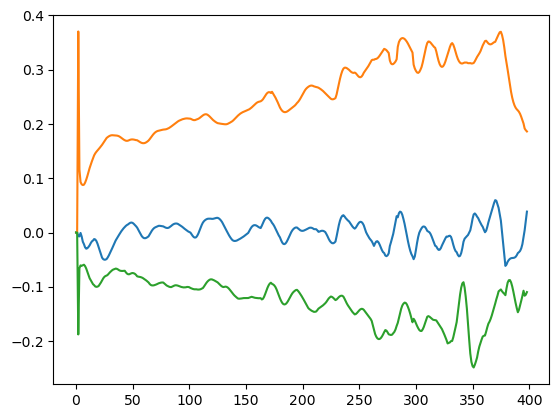

In [104]:
plt.plot(np.stack(sensordata))

In [110]:
model_path = ("/home/eabe/Research/Github/dial-mpc/dial_mpc/models/fruitfly/fruitfly_force_fast.xml")
root = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(root)

In [117]:
model_path = ("/home/eabe/Research/Github/dial-mpc/dial_mpc/models/fruitfly/fruitfly_force_fast.xml")
root = mujoco.MjModel.from_xml_path(model_path)
root.opt.timestep = 0.0002
data = mujoco.MjData(root)
n_frames = qpos.shape[0]
height = 240
width = 320
frames = []
fps = 1/.002
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl[i]
        while data.time < i/fps:
            mujoco.mj_step(root, data)
            times.append(data.time)
            sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
    
# # grab a trajectory
# for i in range(times.shape[0]):
#     data.ctrl = ctrl[i]
#     state = mujoco.mj_step(root,data)
#     rollout.append(state)

media.show_video(pixels, fps=50)
# pixels = env.render(rollout, width=1000, height=1000, camera=3,scene_option=scene_option) 

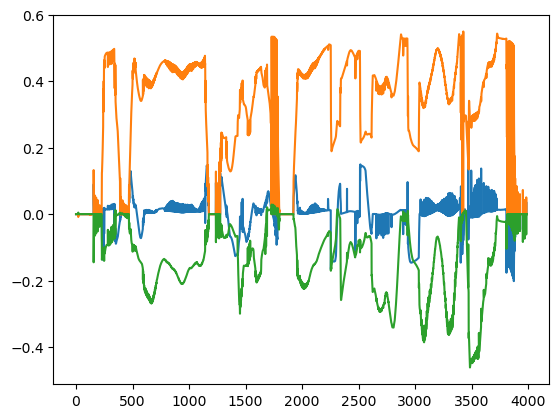

In [118]:
plt.plot(sensordata)

In [ ]:

min_z, max_z = env._healthy_z_range
is_healthy = jp.where(pipeline_state.xpos[env._thorax_idx][2] < min_z, 0.0, 1.0)
is_healthy = jp.where(pipeline_state.xpos[env._thorax_idx][2] > max_z, 0.0, is_healthy)
if env._terminate_when_unhealthy:
    healthy_reward = env._healthy_reward
else:
    healthy_reward = env._healthy_reward * is_healthy


In [ ]:

# obs = env._get_obs(pipeline_state, state.info, state.obs)
joint_angles = pipeline_state.q[7:]
joint_vel = pipeline_state.qd  ##### need to restrict to only legs

# foot contact data based on z-position
foot_pos = pipeline_state.site_xpos[
    env._endeff_idxs
]  # pytype: disable=attribute-error
foot_contact_z = foot_pos[:, 2] - env._foot_radius
contact = foot_contact_z < -.141  # a mm or less off the floor
# contact_filt_mm = contact | state.info["last_contact"]
# contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]


In [ ]:
foot_contact_z, contact

(Array([-0.14083232, -0.14218473, -0.1508358 , -0.14566207, -0.13292545,
        -0.11422561], dtype=float32),
 Array([False,  True,  True,  True, False, False], dtype=bool))

In [ ]:

# done if joint limits are reached or robot is falling
up = jp.array([0.0, 0.0, 1.0])
done = jp.dot(brax_math.rotate(up, x.rot[env._thorax_idx]), up) < 0
done |= jp.any(joint_angles < env.lowers)
done |= jp.any(joint_angles > env.uppers)
done |= pipeline_state.x.pos[env._thorax_idx, 2] < min_z
done |= pipeline_state.x.pos[env._thorax_idx, 2] > max_z

done

Array(False, dtype=bool)

# Viz

In [ ]:
# xml_path = task_path / 'task_viz.xml'
# xml_path = task_path.parent / 'fruitfly_force_pair.xml'
# xml_path = task_path.parent / 'fruitfly_force_seq.xml'
# xml_path = task_path.parent / 'fruitfly_freeforce.xml'

mj_model = mujoco.MjModel.from_xml_path(cfg.dataset.env_args.mjcf_path)

mj_data = mujoco.MjData(mj_model)

mocap_names = [mj_model.site(i).name for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
mocap_id = [mj_model.site(i).id for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
site_names = [mj_model.site(i).name for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
site_id = [mj_model.site(i).id for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
# for id in mocap_id:
#     mj_model.site(id).rgba = [0,1,0,1]
# for id in site_id:
#     mj_model.site(id).rgba = [1,0,0,1]

# geom_names = [mj_model.geom(i).name for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]
# geom_ids = [mj_model.geom(i).id for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]

# for id in geom_ids[5:]:
#     mj_model.geom(id).group = 4

camera_id = 0

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 0, 1, 0]
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_FOG] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_STATIC] = False

# mj_data.qpos = np.concatenate([qposes_stac[n] for n in range(0,2)])
# mj_data.qpos = qposes_stac[0]
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=420, width=550)


# mj_data.mocap_pos = mod_frames[0].copy()
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera=camera_id, scene_option=scene_option)
pixels = renderer.render()
PIL.Image.fromarray(pixels)
# im = PIL.Image.fromarray(pixels)
# im.save(fig_path/'init_camera{}.png'.format(camera_id),format='png')